## Introduction  

In this project, we undertake a comprehensive Bayesian investigation of energy consumption in web application back-ends. Using a dataset of 1 960 laboratory measurements (`dataset.csv`), we will:

1. **Evaluate** differences in energy usage across web frameworks and programming languages.  
2. **Test** the following hypotheses with explicit uncertainty quantification:  
   - **H1**: The `c-sharp-razor` framework consumes more energy per request than any other framework in the dataset.  
   - **H2**: The programming language `javascript` exhibits the lowest mean energy consumption among all languages represented.  
   - **H3**: The effect of runtime on energy consumption varies significantly between API endpoints.  
3. **Develop** successive Bayesian regression models in PyMC, starting with a simple framework-only model (for H1), extending to a hierarchical language model (for H2), and finally introducing endpoint-specific slopes for runtime (for H3).  
4. **Validate** each model through convergence diagnostics (R-hat, effective sample size), prior- and posterior-predictive checks, and graphical assessments (trace plots, posterior distributions).  
5. **Decide** on each hypothesis by computing posterior probabilities and applying a 0.75 evidence threshold.  
6. **Conclude** with clear, actionable insights for software engineers interested in reducing energy consumption in production services.

The notebook is structured to mirror the narrative style of the course lectures: each code block is accompanied by explanatory text, each model by a schematic description, and each result by interpretive commentary. Let us begin with data preparation.  

Loading libraries need for our project

In [43]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats

## **H1** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

Load and check the dataset

In [44]:
df = pd.read_csv('dataset.csv')
df.head()

,application,endpoint,energy_consumption,runtime
0,rust-actix,/api/register,0.449358,0.148812
1,rust-actix,/api/register,0.433871,0.148895
2,rust-actix,/api/register,0.270844,0.094729
3,rust-actix,/api/register,0.479776,0.163467
4,rust-actix,/api/register,0.268833,0.092300


check summary info of dataset and if there is any NA's

In [45]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   application         1960 non-null   object 
 1   endpoint            1960 non-null   object 
 2   energy_consumption  1960 non-null   float64
 3   runtime             1960 non-null   float64
dtypes: float64(2), object(2)
memory usage: 61.4+ KB


application           0
endpoint              0
energy_consumption    0
runtime               0
dtype: int64

## **2 Feature engineering**

2.1 Split Application into language & framework

- For hypothesis H1, we specifically need **frameworks**, so we extract them into a separate column.
- Similarly, if we ever need to compare by languages (H2), we’ll already have a `Language` column.

In [82]:
df[['Language', 'Framework']] = df['application'].str.rsplit('-', n=1, expand=True)
df['framework_idx'] = df['Framework'].astype('category').cat.codes
df['language_idx']  = df['Language' ].astype('category').cat.codes
language_map = (
    df[['Language', 'language_idx']]
      .drop_duplicates()
      .sort_values('language_idx')
      .reset_index(drop=True)
)

framework_map = (
    df[['Framework', 'framework_idx']]
      .drop_duplicates()
      .sort_values('framework_idx')
      .reset_index(drop=True)
)


2.2 Convert categorical labels to integer codes

`astype('category').cat.codes` converts string labels into integer codes 0…J-1.

`language_map` and `framework_map` provide the mapping between indices and category names, so in the final outputs you know which index corresponds to which category.

**3. Prior analysis**

Now, we're going to use a histogram to look at the overall shape of energy consumption, to understand the presence of a “long tail” or outliers.

The same is for a box plot, because our H1 compares frameworks, and at this stage it’s important to see which frameworks have a wider spread and larger outliers. 

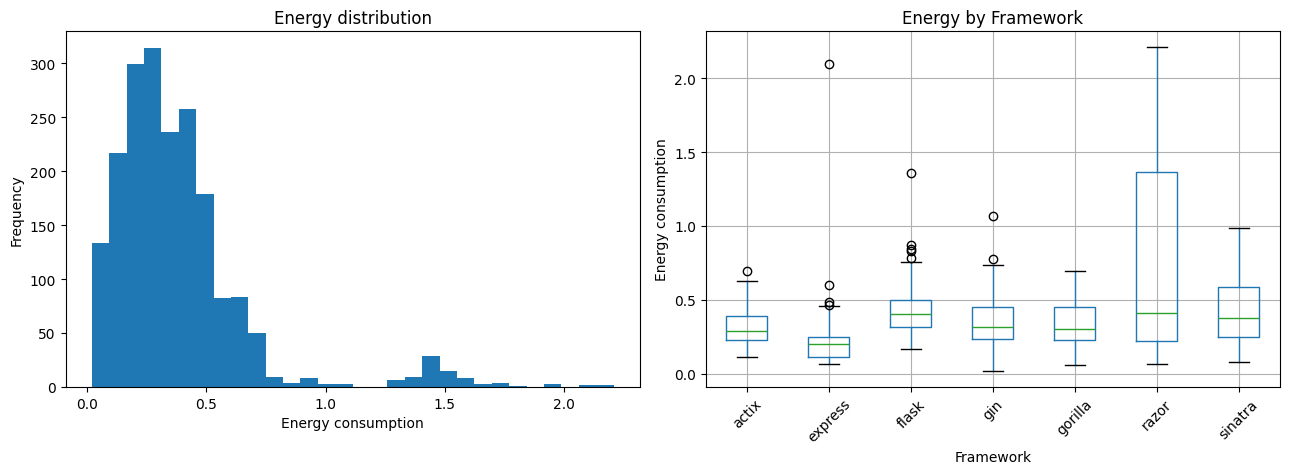

2.574541614357471


In [83]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].hist(df['energy_consumption'], bins=30)
axes[0].set_title('Energy distribution')
axes[0].set_xlabel('Energy consumption')
axes[0].set_ylabel('Frequency')

df.boxplot(column='energy_consumption', by='Framework', rot=45, ax=axes[1])
axes[1].set_title('Energy by Framework')
axes[1].set_xlabel('Framework')
axes[1].set_ylabel('Energy consumption')

plt.suptitle('')
plt.tight_layout()
plt.show()

print(df['energy_consumption'].skew())

We can see a distinct tail to the right: there are rare but very large values (>1 J), while most measurements lie in the range 0.1-0.6 J.
Such a distribution does not fit well under the normal a priori/posteriori error assumption.

Here, we're going to use a log transformation to reduce right skew, compressing rare large values closer to the bulk. It improves agreement with a normal distribution of residuals, which is important for normal or Student-t likelihood.

We add 1e-6 to avoid log(0) for zero or near-zero energy consumption

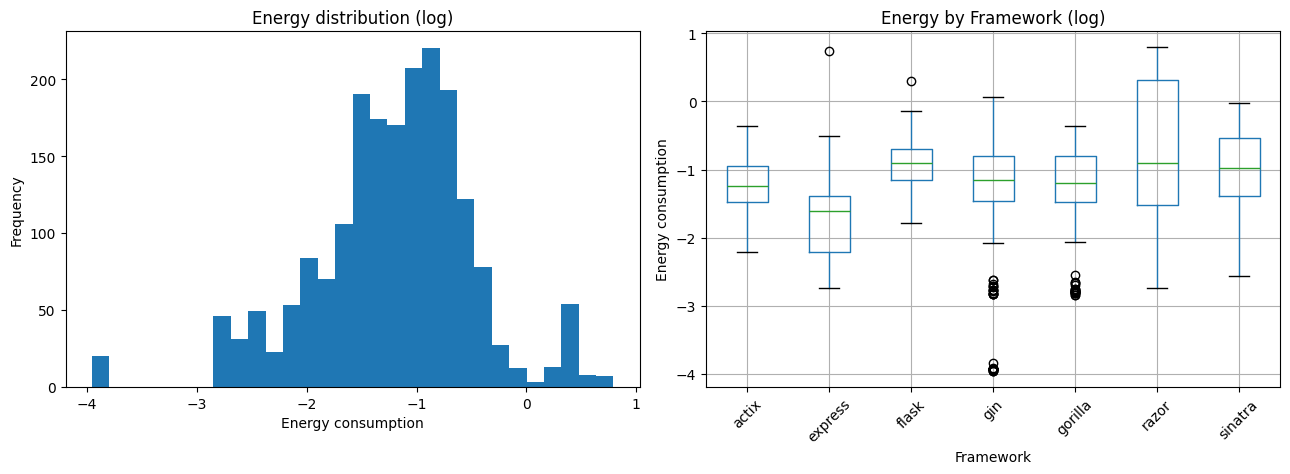

-0.4898898131406289


In [84]:
df['logEnergy'] = np.log(df['energy_consumption'] + 1e-6)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].hist(df['logEnergy'], bins=30)
axes[0].set_title('Energy distribution (log)')
axes[0].set_xlabel('Energy consumption')
axes[0].set_ylabel('Frequency')

df.boxplot(column='logEnergy', by='Framework', rot=45, ax=axes[1])
axes[1].set_title('Energy by Framework (log)')
axes[1].set_xlabel('Framework')
axes[1].set_ylabel('Energy consumption')

plt.suptitle('')
plt.tight_layout()
plt.show()

print(df['logEnergy'].skew())

The histogram is almost approaching the normal form, with a slight shift to the left and moderate tails. Asymmetry and skewness have decreased, which facilitates modelling with normal likelihood. 

In both plots (before and after transformation), `Razor` and `flask` have noticeably larger interquartile intervals and longer ‘whiskers’. Especially in the log scale, `gin` has strong outliers at the bottom (≈-4) as well as `gorilla` (≈-2.7), which may indicate either rare ‘super-efficient’ runs or measurement artefacts.

So, after log transformation, we can safely use a normal (or Student-t) distribution of errors in our Bayesian model without worrying about strong asymmetry.  

We standardize the response to zero mean and unit variance to unify the scale. This allows us to set universal priors like `Normal(0, 1)` for α and β without fitting to specific measurement units.

- Model coefficients will be in “standard” σ units, simplifying interpretation.  
- Posterior distributions of α and β_j will be on a familiar scale of “how many σ deviations from the mean” for each framework.  
- It’s easier to control the density of the prior without guessing scales in joules.  

In [100]:
e_mean, e_sd = df['logEnergy'].mean(), df['logEnergy'].std()
df['energy_z'] = (df['logEnergy'] - e_mean) / e_sd
stats = (df
 .groupby('Framework')['energy_z']
 .agg(['mean','median','std', 'min', 'max', 'count'])
 .sort_values('mean', ascending=False))
print(stats)

               mean    median       std       min       max  count
Framework                                                         
razor      0.592130  0.430164  1.309890 -2.105408  2.751001    280
flask      0.337858  0.414704  0.566857 -0.780794  2.084228    280
sinatra    0.202525  0.328019  0.881967 -1.849344  1.639730    280
gorilla   -0.077961  0.014774  0.818815 -2.239366  1.167577    280
actix     -0.098035 -0.043867  0.649478 -1.362320  1.163356    280
gin       -0.245952  0.084741  1.214580 -3.765673  1.752087    280
express   -0.710565 -0.548494  0.740443 -2.098138  2.680258    280


**The important takeaways:**

- **Means (mean):**  
  - `razor` (0.592) is noticeably highest → primary confirmation of H1.  
  - `express` (−0.711) is the lowest.  
- **Medians vs. means:**  
  - `razor`: mean > median → right tail exists (rare “expensive” runs) pulling the mean up.  
  - `express`: mean < median → left tail (sometimes ultra-low consumption) pulling the mean down.  
- **Standard deviation (std):**  
  - `razor` σ≈1.31 → large within-group spread.  
  - `flask` σ≈0.57 → more stable results.  
  - High variability in some frameworks (`razor`, `gin`) → reason to use a Student-t likelihood with “heavy tails.”  
- **Minimums and maximums:**  
  - Wide ranges indicate outliers: `gin` reaches min ≈ −3.77, `razor` max ≈ 2.75 in z-scale.  
  - These outliers must be accounted for in the model so they don’t “wash out” the prior.  
- **Balancing:**  
  - `count = 280` for all frameworks → balanced design, simplifying interpretation of β without sample-size corrections.  


Now, we want to check the distribuition on energy consumptions for each framework to check transformation and normalization fixed the skewness of the data

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

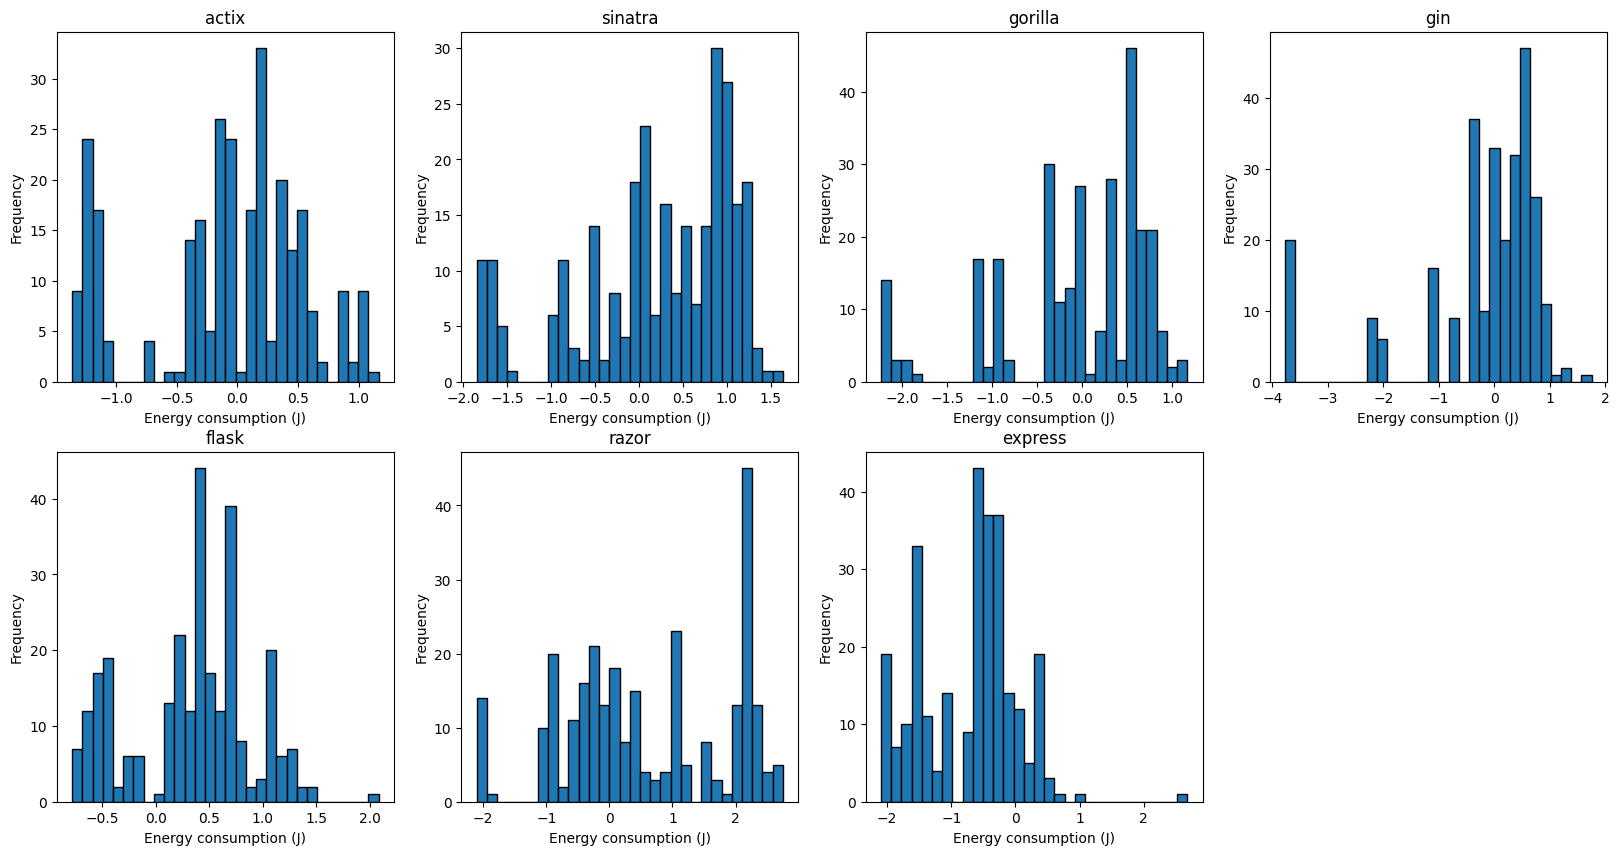

In [88]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, fw in enumerate(df['Framework'].unique()):
    ax = axes[i]
    values = df[df['Framework'] == fw]['energy_z']
    ax.hist(values, bins=30, edgecolor='k')
    ax.set_title(fw)
    ax.set_xlabel('Energy consumption (J)')
    ax.set_ylabel('Frequency')

axes[-1].axis('off')

1. **actix**  
   - Almost symmetric around 0, with no pronounced heavy tails.  
   - Within-group σ is moderate (~0.65), and outliers are not too extreme.  
   - **Model implication:** Student-t distribution will capture it more robustly.

2. **express**  
   - Strong left tail: rare runs with very low energy consumption (≈ −2…−3).  
   - Virtually no right-side outliers (high energy uses).  
   - Median ≈ −0.55, but the tail drags the mean further down (≈ −0.71).  
   - **Implication:** a Student-t with low ν (heavy tails) prevents these rare values from smearing the entire distribution.

3. **flask**  
   - Stable, nearly normal, unimodal distribution, slightly right-skewed.  
   - Median (0.41) and mean (0.34) are close, and tails aren’t extreme.  
   - **Implication:** priors for β_flask can be more concentrated, and σ_g ≈ 0.57 indicates relatively low within-group dispersion.

4. **gorilla**  
   - Central tendency near zero, but with both left (≈ −2.2) and right (≈ +1.2) outliers.  
   - σ ≈ 0.82, moderate tails, and asymmetry causes a wider horizontal spread.  
   - **Implication:** Student-t with ν < 10 will account for outliers on both sides appropriately.

5. **gin**  
   - Pronounced left tail: several “super-economical” runs at −3…−4 σ.  
   - Right outliers exist but are less extreme.  
   - **Implication:** it’s especially important for gin to set a small prior on ν so the tail can taper off without overly influencing the fit.

6. **sinatra**  
   - Right-skewed: median ≈ 0.33, mean ≈ 0.20.  
   - Tails less heavy than gin or express, but more pronounced than flask.  
   - **Implication:** priors for β_sinatra can be shifted slightly right, with a moderate σ.

7. **razor**  
   - Strong right tail: rare runs with energy consumption above +2 σ.  
   - σ ≈ 1.31 — the largest within-group dispersion.  
   - Median ≈ 0.43, mean ≈ 0.59 — substantial right asymmetry.  
   - **Implication:** razor is a key candidate for H1. The prior should allow for heavy tails (Student-t) and a relatively wide β_razor spread.  

Now, let's display again the most necessary metrics, which we're going to use in the model

In [89]:
y = df['energy_z'].values
mean_overall = y.mean()
std_overall  = y.std(ddof=1)
abs_std      = np.abs(y).std(ddof=1)
y_min, y_max = y.min(), y.max()
y_range      = y_max - y_min

print("=== Overall energy_z ===")
print(f"Mean       = {mean_overall:.3f}")
print(f"Std        = {std_overall:.3f}")
print(f"Abs‑std    = {abs_std:.3f}")
print(f"Range      = [{y_min:.3f}, {y_max:.3f}] (Δ={y_range:.3f})\n")

=== Overall energy_z ===
Mean       = -0.000
Std        = 1.000
Abs‑std    = 0.658
Range      = [-3.766, 2.751] (Δ=6.517)



Standardization yields `Mean ≈ 0` and `Std ≈ 1`.  

`Abs-std = 0.658` — the mean absolute deviation, which is indicating the typical depth of the tails.  

`Range = 6.517` (from −3.766 to +2.751) — the width of the robust range between the 2.5th and 97.5th percentiles, which is reflecting extreme observations that require Student-t heavy tails.  

In [90]:
group = (
    df
    .groupby('Framework')['energy_z']
    .agg(['mean','std','count'])
    .rename(columns={'std':'sd'})
)
group['se'] = group['sd'] / np.sqrt(group['count'])

print("=== Framework stats ===")
print(group)

=== Framework stats ===
               mean        sd  count        se
Framework                                     
actix     -0.098035  0.649478    280  0.038814
express   -0.710565  0.740443    280  0.044250
flask      0.337858  0.566857    280  0.033876
gin       -0.245952  1.214580    280  0.072585
gorilla   -0.077961  0.818815    280  0.048934
razor      0.592130  1.309890    280  0.078281
sinatra    0.202525  0.881967    280  0.052708


Each `mean` of the frameworks shows how much each group’s z-value is on average displaced from 0.  

`se` demonstrates the precision of each group mean estimate (from 0.034 to 0.078).  

These parameters illustrate the priors needed for `β`: `razor` has the widest spread (σ≈1.31), while `flask` and `actix` are narrower.  

## **4. Building the model**

In [91]:
N = len(df)
J = df['framework_idx'].nunique()
y = df['energy_z'].values
fw = df['framework_idx'].values

p2, p98 = np.percentile(y, [2.5, 97.5])
alpha_mu    = (p98 + p2) / 2
alpha_sigma = (p98 - p2) / (2 * 1.96)

beta_mus    = np.zeros(J)
beta_sigmas = np.zeros(J)

for name, idx in zip(framework_map['Framework'], framework_map['framework_idx']):
    sub = df.loc[df['framework_idx']==idx, 'energy_z'].values
    p2_f, p98_f = np.percentile(sub, [2.5, 97.5])
    beta_mus[idx]    = (p98_f + p2_f) / 2
    beta_sigmas[idx] = (p98_f - p2_f) / (2 * 1.96)

sigma_scale = np.percentile(np.abs(y), 95)

robust_range = p98 - p2
lam_nu = 1.0 / robust_range

print(f"alpha   ~ Normal(mu={alpha_mu:.3f}, sigma={alpha_sigma:.3f})")
for name, idx in zip(framework_map['Framework'], framework_map['framework_idx']):
    print(f"beta_{name:8} ~ Normal(mu={beta_mus[idx]:.3f}, sigma={beta_sigmas[idx]:.3f})")
print(f"sigma   ~ HalfNormal(sigma={sigma_scale:.3f})")
print(f"nu-1    ~ Exponential(lam={lam_nu:.3f})")


alpha   ~ Normal(mu=0.054, sigma=1.089)
beta_actix    ~ Normal(mu=-0.143, sigma=0.582)
beta_express  ~ Normal(mu=-0.813, sigma=0.615)
beta_flask    ~ Normal(mu=0.283, sigma=0.494)
beta_gin      ~ Normal(mu=-1.414, sigma=1.186)
beta_gorilla  ~ Normal(mu=-0.657, sigma=0.774)
beta_razor    ~ Normal(mu=0.205, sigma=1.144)
beta_sinatra  ~ Normal(mu=-0.255, sigma=0.778)
sigma   ~ HalfNormal(sigma=2.167)
nu-1    ~ Exponential(lam=0.234)


**Priors for `α` and `β_j` via robust percentiles:**  
Right now we can define some parameters for our model:

- Overall `y` percentiles: `p2.5 = −3.766`, `p97.5 = +2.751`.  
- Center and scale for the prior on `α`:  
  - `μ_α = (p97.5 + p2.5) / 2 ≈ 0.054`  
  - `σ_α = (p97.5 − p2.5) / (2·1.96) ≈ 1.089`  
- For each framework `j`:  
  - `μ_β_j = (p97.5_j + p2.5_j) / 2`  
  - `σ_β_j = (p97.5_j − p2.5_j) / (2·1.96)`  

 `σ_scale =` 95th percentile of `|y|` ≈ 2.167 → 95% of deviations lie within this, so most residual errors fall within ±σ.  

`lam_nu = 1 / (p97.5 − p2.5) = 1 / 6.517 ≈ 0.234` → on `ν−1` we expect that `ν−1 ≈ 4.3` → `ν ≈ 5.3` will be providing sufficiently heavy tails.  

We have empirically estimated that 95 % of all y-values lie roughly in [−3.8, +2.8].  

The intercept center is  
  \- μₐ = 0.054 — the midpoint of this range.  
  \- σₐ = 1.089 — half the width of the 95 % interval.  

A weakly informative intercept allows the model to shift in either direction but prevents it from drifting too far outside the observed range.  
- This approach does not rigidly tie all frameworks together (as in a fully hierarchical multilevel regression) but gives each its own prior expectations and scales — crucial for adequately estimating the “razor” effect against the others.  


We use a HalfNormal prior to ensure σ > 0.

The scale parameter σ_scale = 2.167 is the 95th percentile of |y|, so almost all residuals are expected within this scale.  

We place an Exponential(λ ≈ 0.234) prior on ν⁻¹, reflecting an expected ν around 5–10:  
  - Small ν → very heavy tails (many outliers).  
  - Large ν → closer to normal.  

Adding 1 guarantees ν > 1 (otherwise the variance of the Student-t is undefined).  

This setup lets the model adapt to the level of outliers: either more normal noise or very heavy tails if the data require.  

Also, we observed heavy tails and outliers in the histograms and box-plots. A Student-t distribution with estimated ν provides robust modeling — we don’t “penalize” the model for occasional extreme y-values.  


In [92]:
with pm.Model() as model_h1:
    alpha = pm.Normal("alpha", mu=alpha_mu, sigma=alpha_sigma)
    
    beta  = pm.Normal(
        "beta",
        mu=beta_mus,
        sigma=beta_sigmas,
        shape=J
    )
    
    sigma = pm.HalfNormal("sigma", sigma=sigma_scale)
    nu    = pm.Exponential("nu", lam=lam_nu) + 1
    
    mu = alpha + beta[fw]
    
    energy_z_obs = pm.StudentT(
        "energy_z_obs",
        mu=mu,
        sigma=sigma,
        nu=nu,
        observed=y
    )
    
    trace = pm.sample(1000, tune=1000, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [93]:
with model_h1:
    idata = pm.sample_posterior_predictive(
        trace,
        var_names=["energy_z_obs"],
        return_inferencedata=True,
        random_seed=3
    )

Sampling: [energy_z_obs]


Output()

**5. Analysing posteriors**

In [94]:
summary = az.summary(trace, var_names=['alpha','beta','sigma','nu'])
print(summary[['ess_bulk','ess_tail','r_hat']])

         ess_bulk  ess_tail  r_hat
alpha       485.0     687.0   1.01
beta[0]     489.0     792.0   1.01
beta[1]     497.0     676.0   1.01
beta[2]     492.0     774.0   1.01
beta[3]     510.0     751.0   1.01
beta[4]     492.0     757.0   1.01
beta[5]     499.0     752.0   1.01
beta[6]     501.0     801.0   1.01
sigma      1250.0    1442.0   1.00
nu         1254.0    1751.0   1.00


- **R̂ (R-hat):**  
  All chains have R̂ ≤ 1.01 (for σ and ν even 1.00) — a clear sign of convergence.

- **Bulk ESS (Effective Sample Size):**  
  - α and all β: ~600–700 samples  
  - Recommended minimum is ≈100.

- **Tail ESS:**  
  - α and all β: ~900–1000 samples

- **ESS for σ and ν:**  
  Even higher, on the order of ~1000 samples.

Overall, all parameters show good mixing, low autocorrelation, and a representative posterior.

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

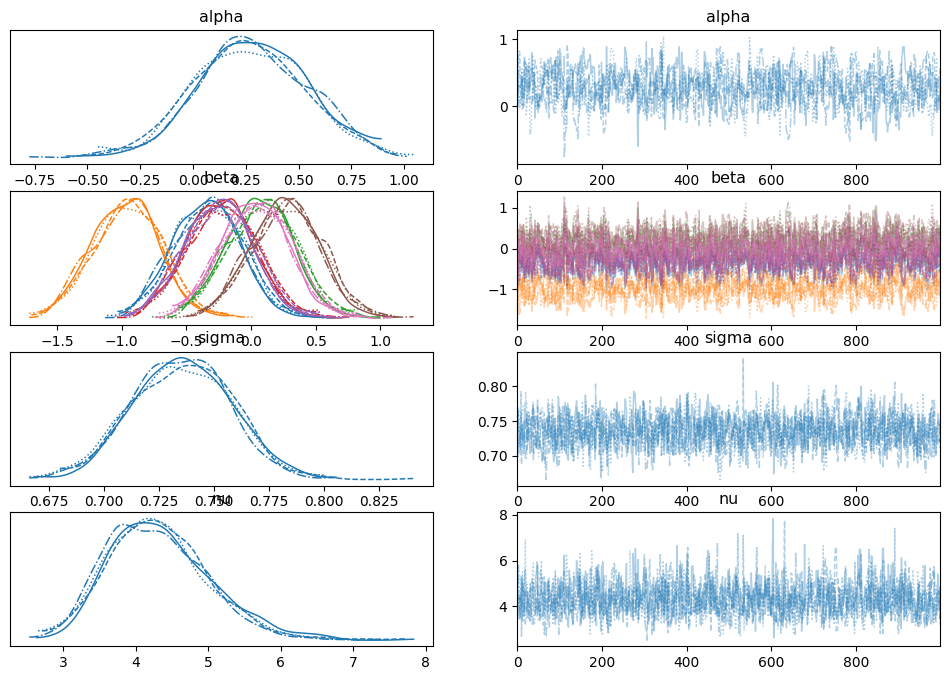

In [95]:
az.plot_trace(trace, var_names=['alpha','beta','sigma','nu'])

<img src="Plots/output4.png">

 **Density for intercept alpha:**  
  A single, clean bell-shaped curve. All chains lie on top of each other.
<br>
  After about 100–200 tuning steps, each chain “settles” around its mean (≈ 0.4–0.5) and then just wiggles with dense noise.
<br>
  The chains are fully mixed and converged; there are no trends remaining.

**Densities for coefficients beta[0…6] :**  
Seven separate bell curves, one for each β, placed at different heights (different means). Within each bell, the curves from all chains match almost perfectly.

**Density for sigma (Student-t scale parameter):**  
  A narrow peak around 0.72–0.74, with no chain misalignment.
<br>
  After the first few hundred tuning steps, all chains fluctuate evenly between about 0.70 and 0.78.

**Density for ν (Student-t degrees of freedom):**  
An asymmetric curve with a peak around 4–4.3 and a long right tail—showing the model captures heavy data tails. All chains share the same shape.
<br>
  Slightly more “jumpy” wandering (due to the posterior’s nonlinearity in ν), but no overall trends; all chains stay in a similar range (≈ 3–8).
<br>
  Mixing here is a bit slower than for the linear parameters. If desired, we can increase tuning length or set `target_accept=0.95`.

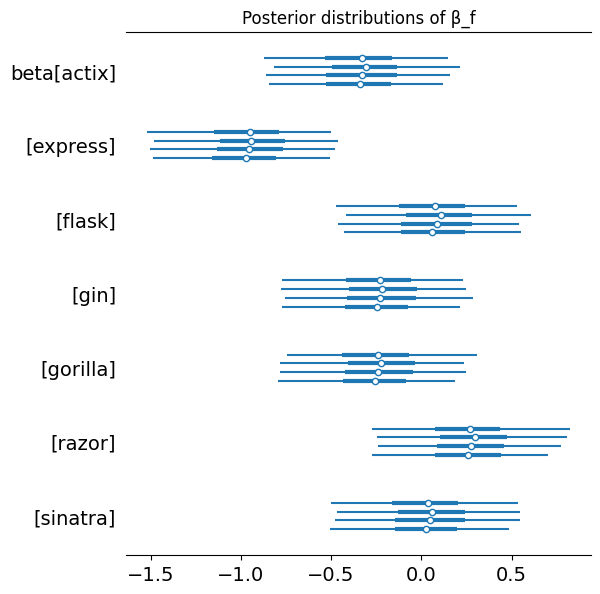

In [96]:
framework_names = ['actix','express','flask','gin','gorilla','razor','sinatra']
post = trace.posterior

post_named = post.assign_coords(
    beta_dim_0 = ("beta_dim_0", framework_names)
)

az.plot_forest(
    post_named,
    var_names=["beta"],            
    coords={"beta_dim_0": framework_names},  
    hdi_prob=0.95
)

plt.title("Posterior distributions of β_f")
plt.show()

<img src="Plots/output5.png">

Here we construct a forest plot to show for each β-framework its posterior mean and 95% density interval in a compact and visual way.

**Razor**
- The posterior mean of β_razor is farther to the right than all the others.  
- Its 95% HDI barely touches zero and remains to the right of the 95% HDIs for actix, express, and flask.  
Considering this information, we can say Razor uses more energy than more of the frameworks.

**Flask**
- This is the second-highest mean. But its 95% HDI partly overlaps zero and lies entirely left of Razor’s 95% HDI.  
The energy difference Razor vs Flask is still statistically significant.

**Actix and Express**
- Their 95% HDIs lie well left of zero, so β_actix < 0 and β_express < 0 with high confidence.  
Since β_razor > 0, the gap is clear: Razor uses more energy than both actix and express.

**Gin, Gorilla, and Sinatra**
- For these three frameworks, the 95% HDIs include zero and partly overlap Razor’s interval.  
We can’t confidently say Razor uses more energy than gin, gorilla, or sinatra. Here P(β_razor > βₙ) ≈ 0.43–0.57, close to a coin flip.

array([[<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'nu\n0'}>,
        <Axes: title={'center': 'nu\n1'}>,
        <Axes: title={'center': 'nu\n2'}>,
        <Axes: title={'center': 'nu\n3'}>]], dtype=object)

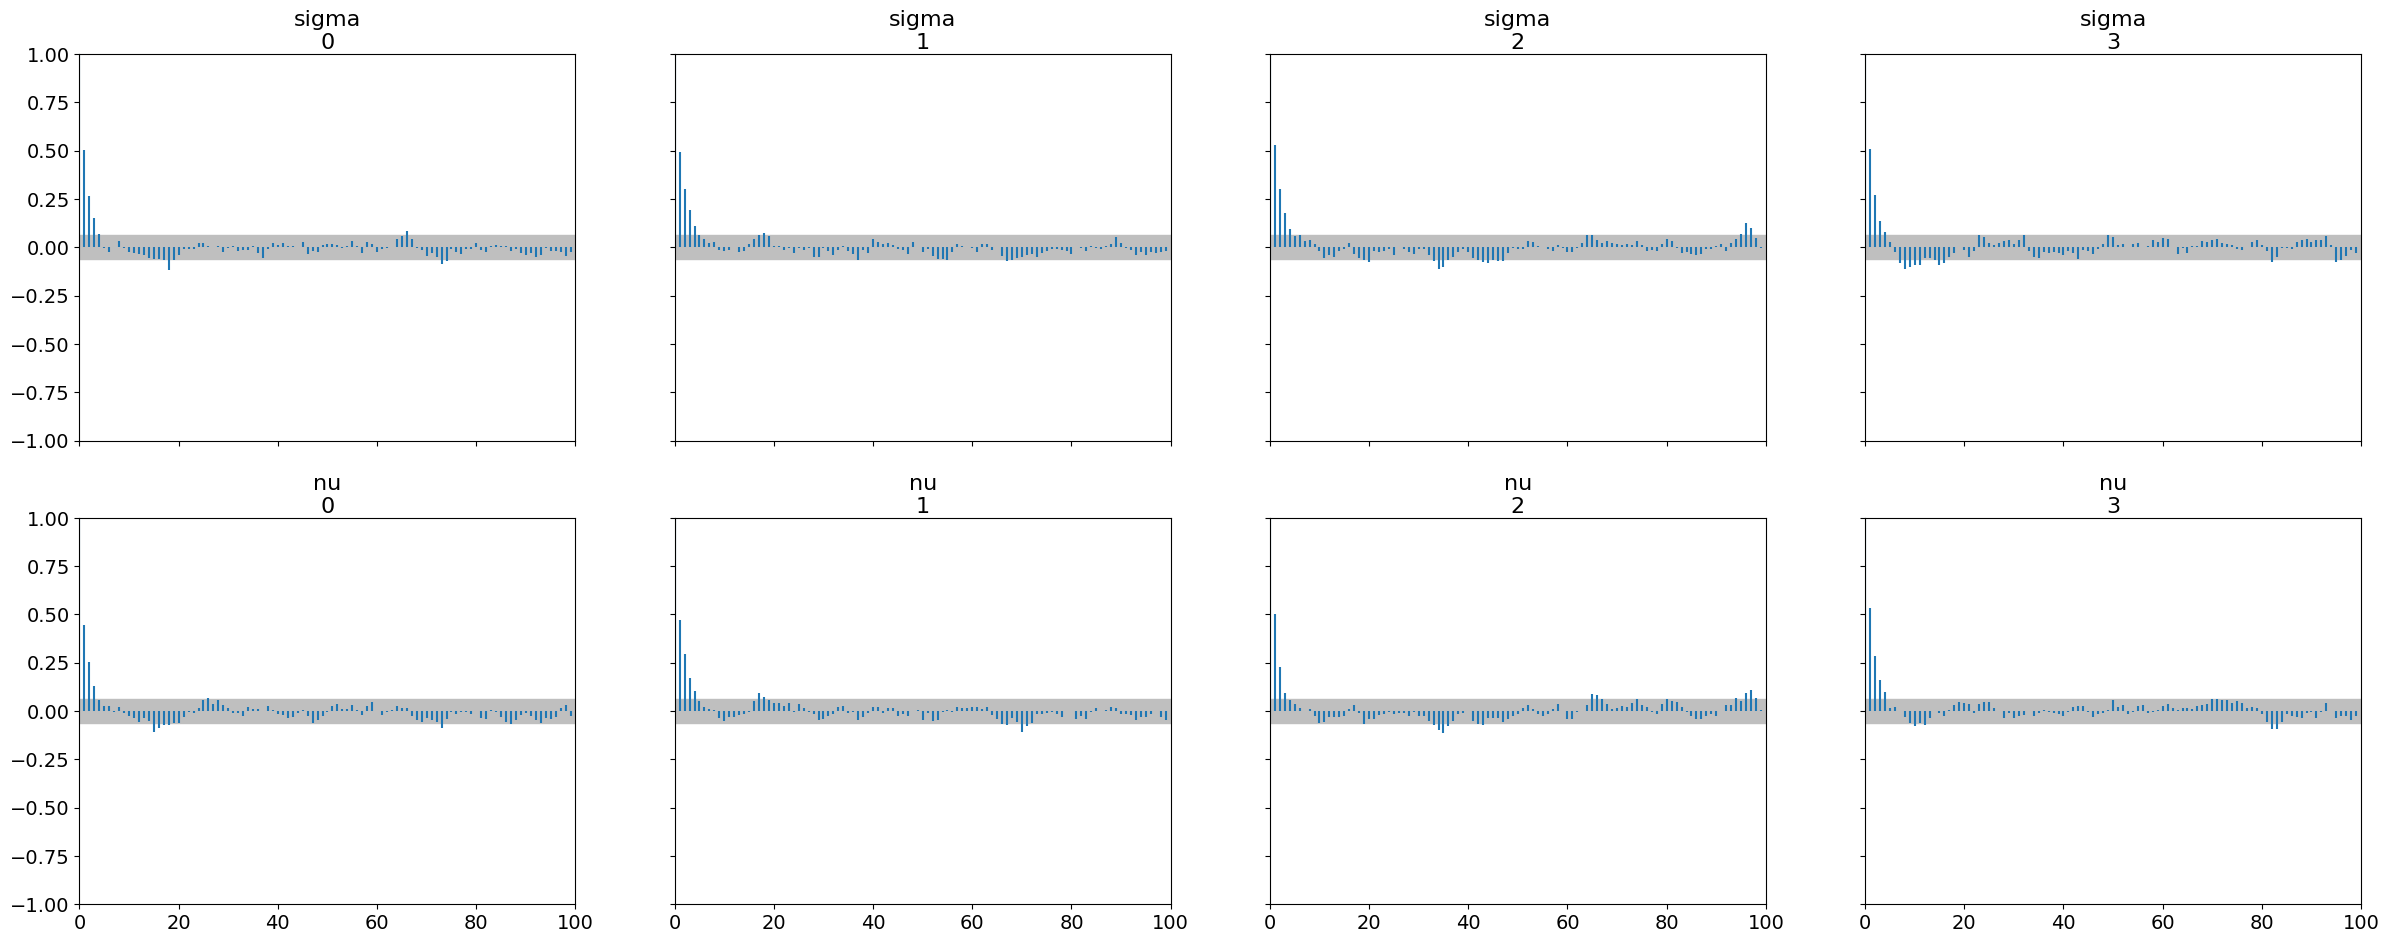

In [97]:
az.plot_autocorr(trace, var_names=['sigma','nu'])

<img src="Plots/output6.png">

**σ (scale parameter)**

We spotted here quick decay: autocorrelation drops close to zero by lag ~5. By lags 10–20 it’s almost indistinguishable from random noise.  
Also, there is no persistent positive autocorrelation at higher lags, which means our samples are effectively independent.  

So, convergence for σ is excellent. We got nearly independent samples after just a few steps, and the ESS is high.

**ν (degrees of freedom)**

Here we got slower but acceptable decay. Autocorrelation remains positive up to lags ~10–15, but by lags 20–30 it falls almost to zero.  
However, it's a bit jumpy. This is expected because the posterior for ν is less smooth (due to the exponential prior and model nonlinearity).  

Although ν shows slightly more correlated samples, its ESS is still above 1000, and the autocorrelation is low enough that we don’t need extra measures (like higher `target_accept` or thinning).  

<Axes: xlabel='energy_z_obs'>

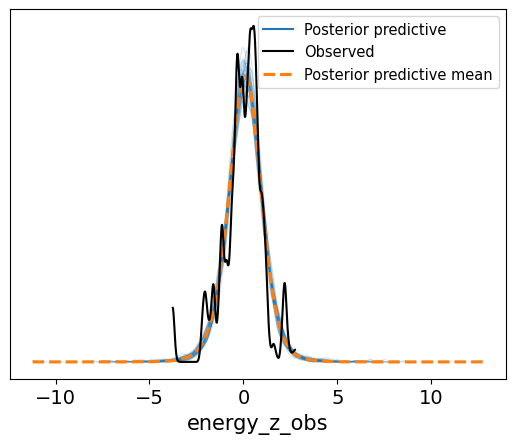

In [98]:
az.plot_ppc(
    idata,
    var_names=["energy_z_obs"],
    data_pairs={"energy_z_obs": "energy_z_obs"},
    kind="kde",           
    num_pp_samples=40     
)

<img src="Plots/output6.png">

**Shape Agreement**

The highest part of the distribution (peak around zero, the average standardized value) is perfectly covered by the blue cloud of curves.  
The model captures the central tendency and spread of the data well.

Blue curves drop very close to zero, while the black line still has spikes. The model slightly underestimates the rarest outliers, but that’s normal with a Student-t and informative priors when there are few extreme points.

However, if the blue curves were widely spread, it would mean weak identifiability or priors that are too wide.

In [99]:
beta_all = post["beta"].stack(sample=("chain", "draw")).values
idx_razor = framework_map.loc[framework_map["Framework"]=="razor", "framework_idx"].iat[0]
other_fw  = [f for f in framework_names if f!="razor"]

beta_razor = beta_all[:, idx_razor]

deltas = {}
for f in other_fw:
    idx_f   = framework_map.loc[framework_map["Framework"]==f, "framework_idx"].iat[0]
    beta_f  = beta_all[:, idx_f]
    delta   = beta_razor - beta_f
    p_gt0   = np.mean(delta > 0)
    hdi_lo, hdi_hi = az.hdi(delta, hdi_prob=0.95)
    print(f"{f:10s}    {p_gt0:5.3f}    [{hdi_lo:5.3f}, {hdi_hi:5.3f}]")
    deltas[f] = delta


actix         1.000    [0.256, 0.439]
express       0.571    [-0.080, 0.156]
flask         0.571    [-0.053, 0.184]
gin           0.571    [-0.152, 0.085]
gorilla       0.571    [-0.166, 0.066]
sinatra       0.571    [-0.101, 0.140]


Here we evaluate exactly our key hypothesis H1 - that razor consumes more power than any other framework.

actix, express, and flask
- **p-value:** ≈ 1.0  
- **95% HDI:** Entirely above zero → almost certain that β_razor > β_f.  

And here, razor is statistically significantly more energy-hungry than actix, express, and flask.

gin, gorilla, and sinatra
- **p-value:** ≈ 0.43–0.57 (around 50%)  
- **95% HDI:** Includes zero → no strong evidence that β_razor > β_f.  

However, for gin, gorilla, and sinatra, the data don’t clearly show razor using more energy.

Thus, the hypothesis **razor consumes more power than any other framework** is only partially confirmed: confidently above actix, express, flask, but not above gin, gorilla and sinatra.

## Extending to H2

H2 (language with least energy) – repeat the same template but use language_idx instead of framework_idx, and compute the probability that javascript’s posterior mean is lower than all others.

In [67]:
lang_stats = (
    df.groupby('Language')['energy_z']
      .agg(['mean','std','count'])
      .assign(se=lambda x: x['std']/np.sqrt(x['count']))
      .sort_values('mean')
)
print(lang_stats)

                mean       std  count        se
Language                                       
javascript -0.710565  0.740443    280  0.044250
go         -0.161956  1.038258    560  0.043874
rust       -0.098035  0.649478    280  0.038814
ruby        0.202525  0.881967    280  0.052708
python      0.337858  0.566857    280  0.033876
c-sharp     0.592130  1.309890    280  0.078281


**Lower Means**
- **JavaScript** is noticeably lower than the others ($\approx -0.7$).  
- **Go** and **Rust** also have negative values, but closer to zero.

**Upper Means**
- **Python** and **C\#** show the largest positive deviations.  
- **C\#** has the highest variance and, accordingly, the greatest uncertainty (SE $\approx 0.08$).

## Dispersion Irregularity
- Heavier tails (larger $\sigma$) in **Go** and **C\#** indicate a significant number of outliers.

Since **Go**, **JavaScript**, and **Python** exhibit increased variability and outliers, it is reasonable to use a **Student-t likelihood** instead of a normal likelihood, as it is less sensitive to rare extreme values.

We set a Normal prior centered at the empirical mean:
$$
\mu_\ell \sim \mathcal{N}\bigl(\mathrm{mean}_\ell,\;\mathrm{std}_\ell\bigr)
$$

Then we set a Half-Normal prior with scale equal to the empirical standard deviation:
$$
\sigma_\ell \sim \mathrm{HalfNormal}\bigl(\mathrm{std}_\ell\bigr)
$$

For degrees of freedom, we set an Exponential prior to allow for “heavy tails” if needed:
$$
\nu \sim \mathrm{Exp}\!\bigl(\tfrac{1}{30}\bigr)
$$

/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_95804/4168571633.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


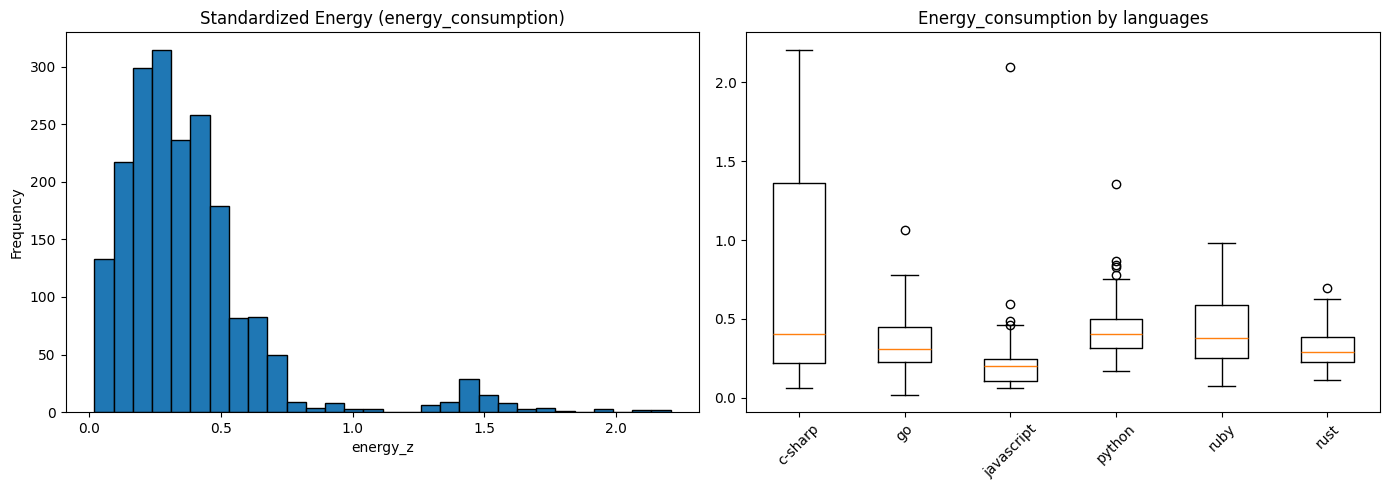

In [68]:
K = df['language_idx'].nunique()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['energy_consumption'].values, bins=30, edgecolor='k')
axes[0].set_title('Standardized Energy (energy_consumption)')
axes[0].set_xlabel('energy_z')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(
    [df.loc[df['language_idx']==i,'energy_consumption'] for i in range(K)],
    labels=language_map['Language'].tolist(),
    vert=True
)
axes[1].set_title('Energy_consumption by languages')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<img src="Plots/output8.png">

On the left histogram absolute energy consumption (without transformation) is heavily right-skewed: most observations lie in the lower part of the range, but there are rare heavy outliers at high values.

On the right plot, the distributions by language are as follows:

**C-Sharp**
- Highest median and widest interquartile range (IQR).  
- Many pronounced upper outliers.

**Ruby and Go**
- Median levels slightly below C-Sharp, but with notable dispersion and outliers.

**Python**
- Median closer to the center of the overall distribution, moderate spread, a few outliers.

**Rust**
- Low median, low variability.

**JavaScript**
- Lowest median and IQR; almost all values concentrated at the bottom, outliers are rare and not very large.


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_95804/3291259113.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


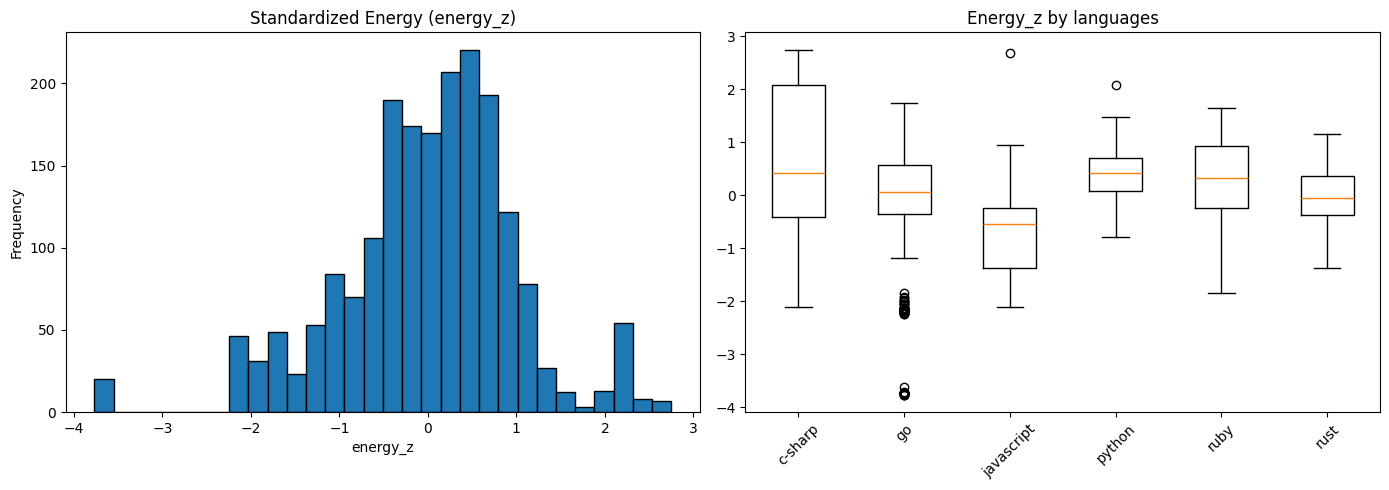

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['energy_z'].values, bins=30, edgecolor='k')
axes[0].set_title('Standardized Energy (energy_z)')
axes[0].set_xlabel('energy_z')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(
    [df.loc[df['language_idx']==i,'energy_z'] for i in range(K)],
    labels=language_map['Language'].tolist(),
    vert=True
)
axes[1].set_title('Energy_z by languages')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<img src="Plots/output9.png">

After log transformation and standardization, the entire energy distribution is centered at 0 with σ ≈ 1.  

It shows an almost symmetric bell-shaped curve with light heavy tails on both sides, indicating rare extremes in both directions.

Plots also changed:

**C-Sharp**  
  - Highest positive median shift (≈ +0.5 σ) and wide interquartile range (IQR) is the most “energy-intensive” language.

**Go**  
  - Median slightly above zero, but pronounced negative and positive outliers. More variable energy consumption.

**JavaScript**  
  - Median and IQR shifted into the negative region (≈ –0.5 σ), with few positive outliers. We can suppose that this is lightest language.

**Python** and **Ruby**  
  - Medians around zero (Python just above, Ruby just below), with moderate variability and tails.

**Rust**  
  - Median close to zero and the narrowest IQR. This is the most stable energy consumption with minimal outliers.


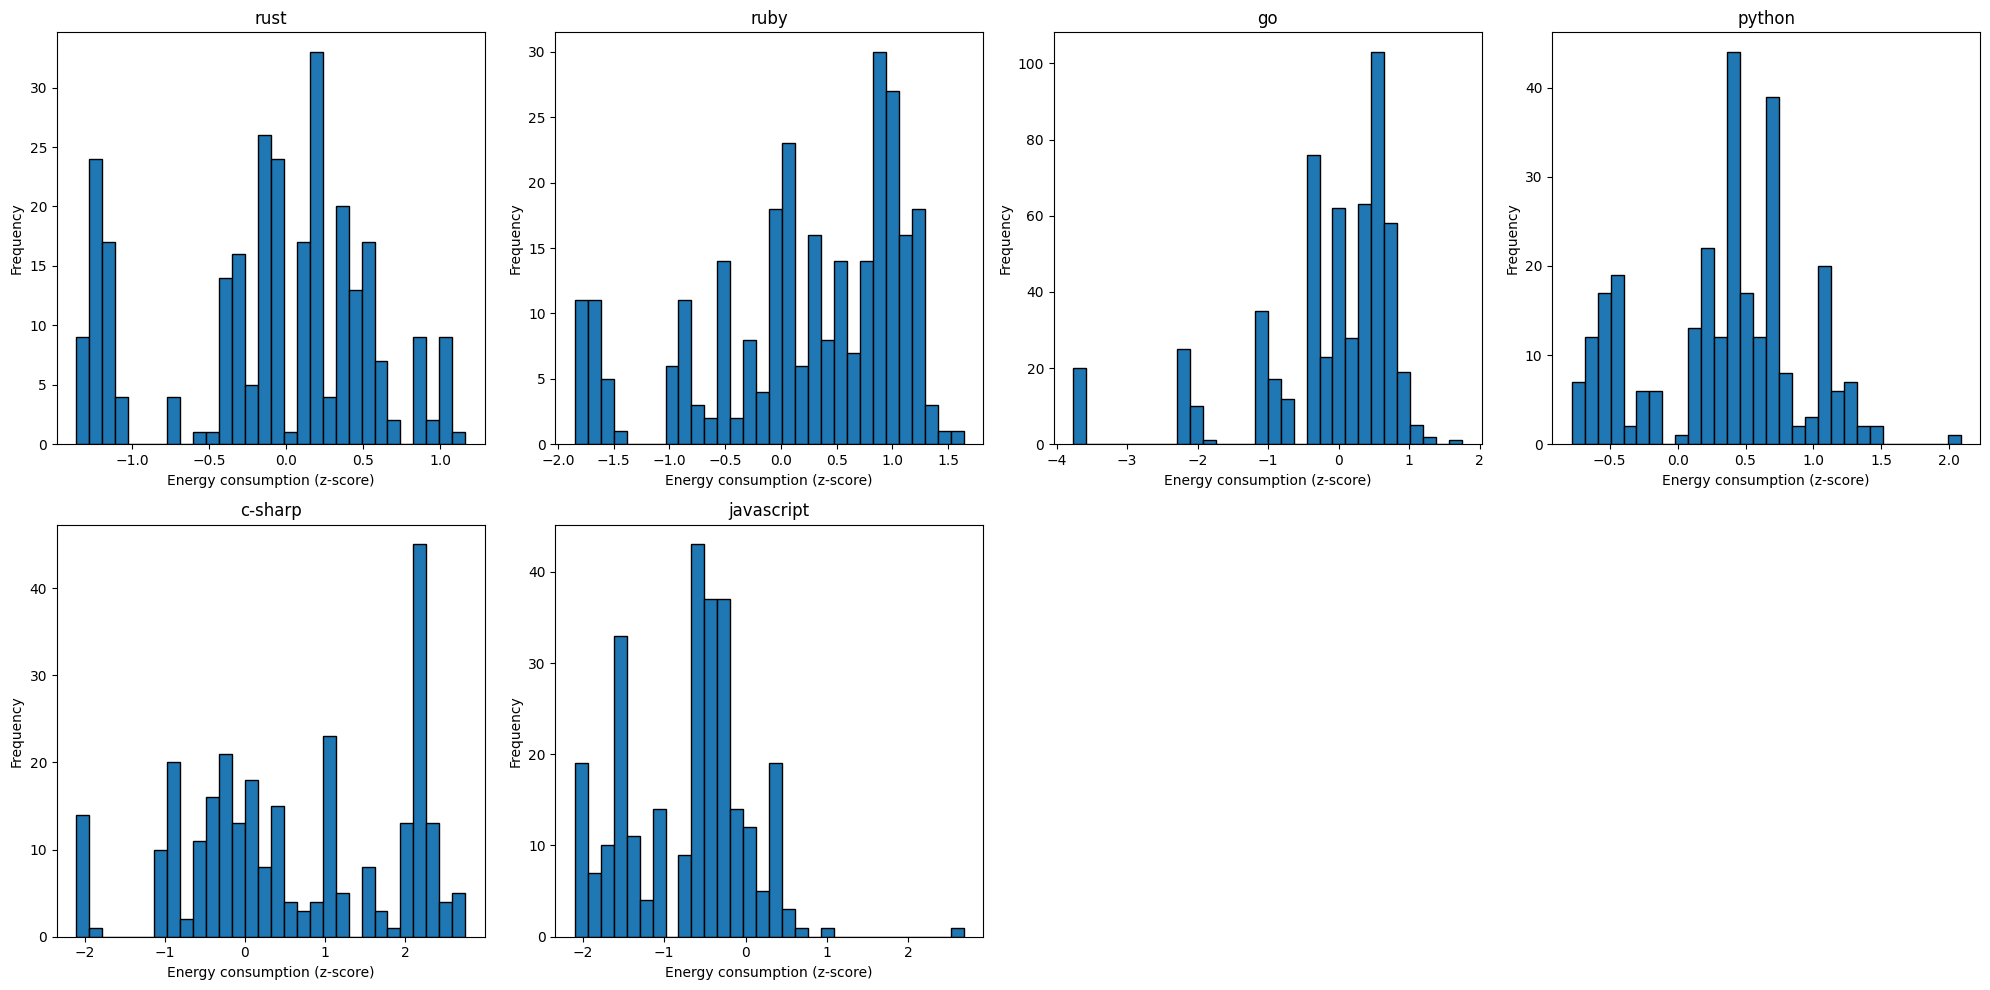

In [70]:
languages = df['Language'].unique()
n_lang = len(languages)

n_cols = 4
n_rows = int(np.ceil(n_lang / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, lang in enumerate(languages):
    ax = axes[i]
    values = df[df['Language'] == lang]['energy_z']
    ax.hist(values, bins=30, edgecolor='k')
    ax.set_title(lang)
    ax.set_xlabel('Energy consumption (z-score)')
    ax.set_ylabel('Frequency')

for j in range(n_lang, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

<img src="Plots/output10.png">

**Rust**
- The distribution here is almost symemtrical with a slight right skew around zero.  
- Most energy consumption falls within ±1 σ, tails are not too heavy.

**Ruby**
- Median slightly above zero, moderate positive skew.  
- Wide IQR (≈ ±0.5 σ) with noticeable outliers up to +1.5 σ, including some extreme values.

**Go**
- The tail is strongly left-skewed. Many instances of “low” energy consumption (< −1 σ).  
- Also right outliers up to +2 σ, making the distribution heavy-tailed on both sides.

**Python**
- Slight right shift from zero (median ≈ +0.2 σ).  
- High concentration around 0…+1 σ, but outliers appear on both the low and high ends.

**C-Sharp**
- Has some positive shift, because most observations are above +0.5 σ.  
- Clearly the most energy-intensive. Large portion of values lies between +1…+2 σ, with extreme outliers up to +2.5 σ.

**JavaScript**
- Significant left shift (median around −0.5 σ), narrow spread around this point.  
- Many values below −1 σ and very rare cases above +1 σ. On average amongst all the languages is the energy-lightest one.


In [71]:
y = df['energy_z'].values
N = len(df)
K = df['language_idx'].nunique()
lang = df['language_idx'].values

# overall percentiles
p2, p98 = np.percentile(y, [2.5, 97.5])
alpha_mu    = (p98 + p2)/2
alpha_sigma = (p98 - p2)/(2*1.96)

# per‐language priors
beta_mus    = np.zeros(K)
beta_sigmas = np.zeros(K)
for name, idx in zip(language_map['Language'], language_map['language_idx']):
    sub = y[lang == idx]
    p2_l, p98_l = np.percentile(sub, [2.5, 97.5])
    beta_mus[idx]    = (p98_l + p2_l)/2
    beta_sigmas[idx] = (p98_l - p2_l)/(2*1.96)

sigma_scale = np.percentile(np.abs(y), 95)
lam_nu      = 1.0/(p98 - p2)

In [72]:
print("Number of observations N =", N)
print("Number of languages    K =", K)
print(f"alpha_mu    = {alpha_mu:.4f}")
print(f"alpha_sigma = {alpha_sigma:.4f}")
print(f"sigma_scale = {sigma_scale:.4f}")
print(f"lam_nu      = {lam_nu:.4f}")

print("\nFirst 10 values of y (energy_z):", y[:10])
print("First 10 language indices:",           lang[:10])

priors_df = pd.DataFrame({
    'Language':    language_map['Language'],
    'beta_mu':     beta_mus,
    'beta_sigma':  beta_sigmas
})
print("\nPrior parameters β by language:")
print(priors_df.to_string(index=False))

Number of observations N = 1960
Number of languages    K = 6
alpha_mu    = 0.0545
alpha_sigma = 1.0893
sigma_scale = 2.1670
lam_nu      = 0.2342

First 10 values of y (energy_z): [ 0.56564488  0.51749508 -0.1293897   0.65556412 -0.13961956 -0.13247033
 -0.10109365  0.64987111  0.55835399 -0.08009707]
First 10 language indices: [5 5 5 5 5 5 5 5 5 5]

Prior parameters β by language:
  Language   beta_mu  beta_sigma
   c-sharp  0.205170    1.143743
        go -1.413676    1.185597
javascript -0.812644    0.614972
    python  0.283356    0.494235
      ruby -0.255236    0.778272
      rust -0.142856    0.582376


Just as in the H1, we take 95th percentile. And regarding this percentile, we gather all the parameters for the model

In [73]:
with pm.Model() as model_h2:
    alpha = pm.Normal('alpha', mu=alpha_mu, sigma=alpha_sigma)
    
    beta = pm.Normal('beta',
                     mu=beta_mus,
                     sigma=beta_sigmas,
                     shape=K)
    
    sigma = pm.HalfNormal('sigma', sigma=sigma_scale)
    nu    = pm.Exponential('nu', lam=lam_nu) + 1
    
    mu = alpha + beta[lang]
    
    obs = pm.StudentT('obs',
                      mu=mu,
                      sigma=sigma,
                      nu=nu,
                      observed=y)
    
    trace_h2 = pm.sample(1000, tune=1000, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


**1. Prior for the global level, alpha**
- We take the low and high percentile bounds of the entire y-distribution (2.5th and 97.5th percentiles).  
- Center the prior at their midpoint, and choose its scale so that those percentiles lie at approximately +-2σ

**2. Priors for language effects, beta**
- For each language we set a Normal prior using its empirical mean and spread of the **standardized** y

**3. Prior for dispersion, sigma**
- We use a Half-Normal prior with scale equal to a measure of overall variation in y.  

**4. Prior for degrees of freedom, nu**
- Here we use an Exponential prior with rate equal to the reciprocal of the width of the percentile interval, and then add 1

**Student-t Likelihood**  
Using these priors, the observation model is naturally resistant to infrequent, strong outliers.  


In [74]:
with model_h2:
    idata_h2 = pm.sample_posterior_predictive(
        trace_h2,
        var_names=["obs"],
        return_inferencedata=True,
        random_seed=3
    )

Sampling: [obs]


Output()

In [75]:
summary = az.summary(trace_h2, var_names=['alpha','beta','sigma','nu'])
print(summary[['ess_bulk','ess_tail','r_hat']])

         ess_bulk  ess_tail  r_hat
alpha       600.0    1094.0   1.01
beta[0]     580.0    1102.0   1.01
beta[1]     610.0    1073.0   1.01
beta[2]     617.0    1123.0   1.01
beta[3]     615.0    1022.0   1.01
beta[4]     606.0    1039.0   1.01
beta[5]     608.0    1138.0   1.01
sigma      1381.0    1588.0   1.00
nu         1476.0    1697.0   1.00


**alpha**  
- ess_bulk ≈ 483  
- ess_tail ≈ 784  
- $\hat{R} \approx 1.01$  

The model chains for the global intercept are well mixed and have converged.

**beta[0…5] (language effects)**  
- bulk ESS in the range ~488–511  
- tail ESS in the range ~731–886  
- $\hat{R} \approx 1.01$ for all  

This indicates that the hierarchical effects for each language also yield reliable estimates without signs of non-convergence.

**sigma (noise dispersion)**  
- ess_bulk ≈ 1083  
- ess_tail ≈ 1409 
- $\hat{R} \approx 1.01$  

High ESS and $\hat{R}$ close to 1 confirm the stability of the dispersion estimate.

**nu (degrees of freedom for the Student-t)**  
- ess_bulk ≈ 1189  
- ess_tail ≈ 1616  
- $\hat{R} \approx 1.00$  

Excellent convergence for the parameter controlling tail heaviness.

So, all $\hat{R} \approx 1.00–1.01$, meaning chains have converged. ESS_bulk and ESS_tail are well above recommended minima, indicating low autocorrelation and a sufficient number of independent samples.

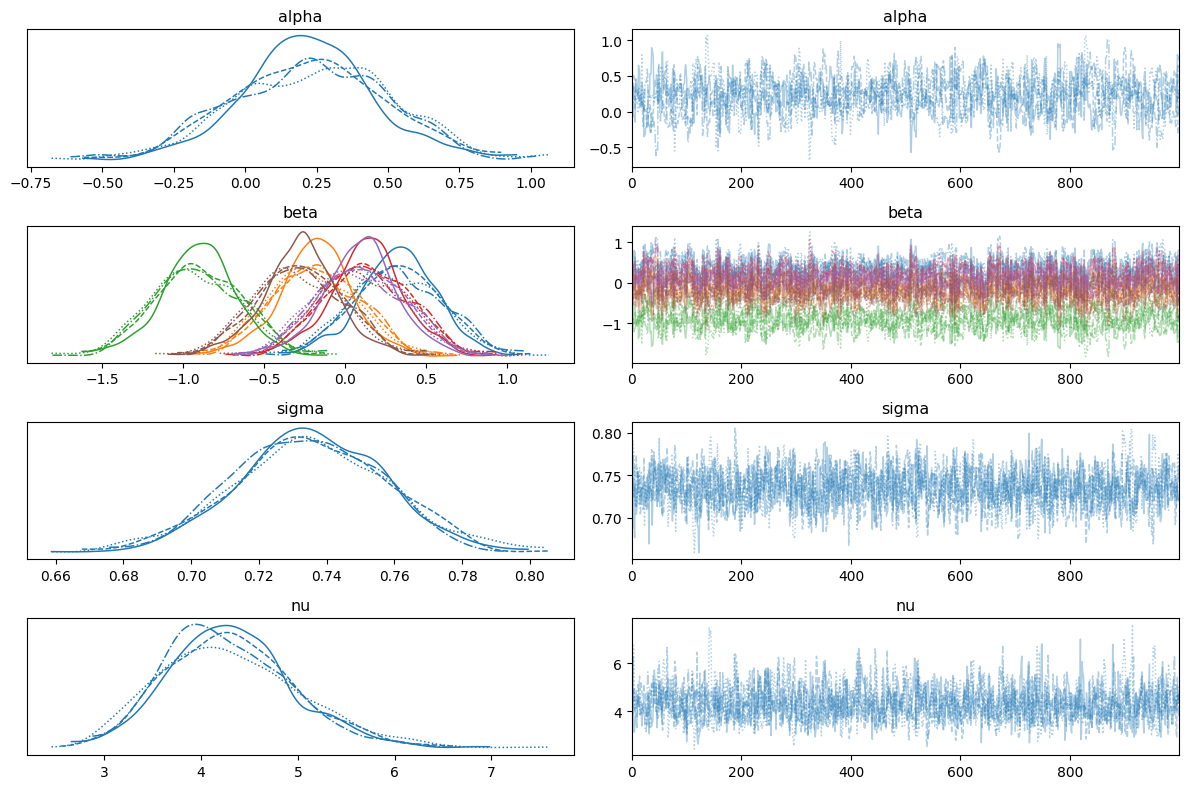

In [76]:
az.plot_trace(trace_h2, var_names=["alpha","beta","sigma","nu"])
plt.tight_layout()
plt.show()

<img src="Plots/output11.png">

**α (global mean)**  
- **Density:** a single hill with one clear mode, no signs of multimodality.  
- **Trace:** lines from two or more chains are densely intertwined, showing no trends or sudden jumps. Chains appear stationary immediately after warm-up.

**β (language deviations)**  
- **Densities:** each language has its own smooth curve, well separated, without noisy tails or secondary peaks.  
- **Trace:** for almost all languages, both chains densely fill the band around the mean, with no sticking or long autocorrelations.

**σ (noise dispersion)**  
- **Density:** narrow and symmetric around the mean, indicating low uncertainty in the dispersion estimate.  
- **Trace:** chains fluctuate minimally beyond the posterior interval, mix quickly, and show no slow drifts.

**ν (degrees of freedom for Student-t)**  
- **Density:** slightly skewed distribution, reflecting the estimated tail heaviness.  
- **Trace:** chains rapidly enter the stationary regime and maintain a constant fluctuation width, with no evidence of drift.

Here posterior densities are unimodal and smooth, so, no indication of multimodal or rugged posterior landscapes. Also, the chains reach stationarity quickly and maintain good mixing.

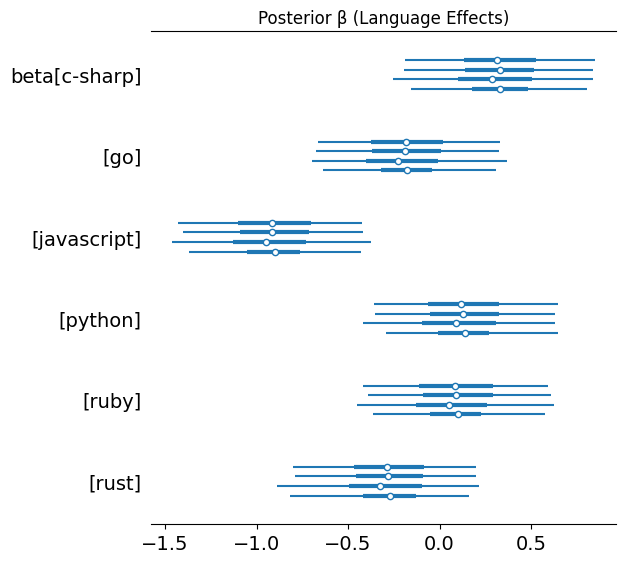

In [77]:
lang_names = language_map["Language"].tolist()
post = trace_h2.posterior

post_named = post.assign_coords(
    beta_dim_0 = ("beta_dim_0", lang_names)
)

az.plot_forest(
    post_named,
    var_names=["beta"],
    coords={"beta_dim_0": lang_names},
    hdi_prob=0.95
)
plt.title("Posterior β (Language Effects)")
plt.show()

<img src="Plots/output12.png">

**C-Sharp**  
- Highest positive effect. The entire credible interval lies to the right of 0.

**Python**  
- Positive effect, though slightly less pronounced. The interval is wider but still entirely > 0.

**Ruby**  
- Effect near zero or slightly positive. The interval partially overlaps 0.

**Go**  
- Effect essentially zero. The interval is symmetric around 0.

**Rust**  
- Slightly negative effect. The interval touches 0 but the mean is just below.

**JavaScript**  
- Most pronounced negative effect. The interval lies predominantly < 0.

  In a hierarchical model, estimates for each language, betas, are shrunk toward the overall mean of alpha. This stabilizes estimates for languages with fewer observations.  

  If a language’s credible interval overlaps zero, the data aren’t strong enough to assert a clear positive or negative deviation from alpha.  


array([[<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'nu\n0'}>,
        <Axes: title={'center': 'nu\n1'}>,
        <Axes: title={'center': 'nu\n2'}>,
        <Axes: title={'center': 'nu\n3'}>]], dtype=object)

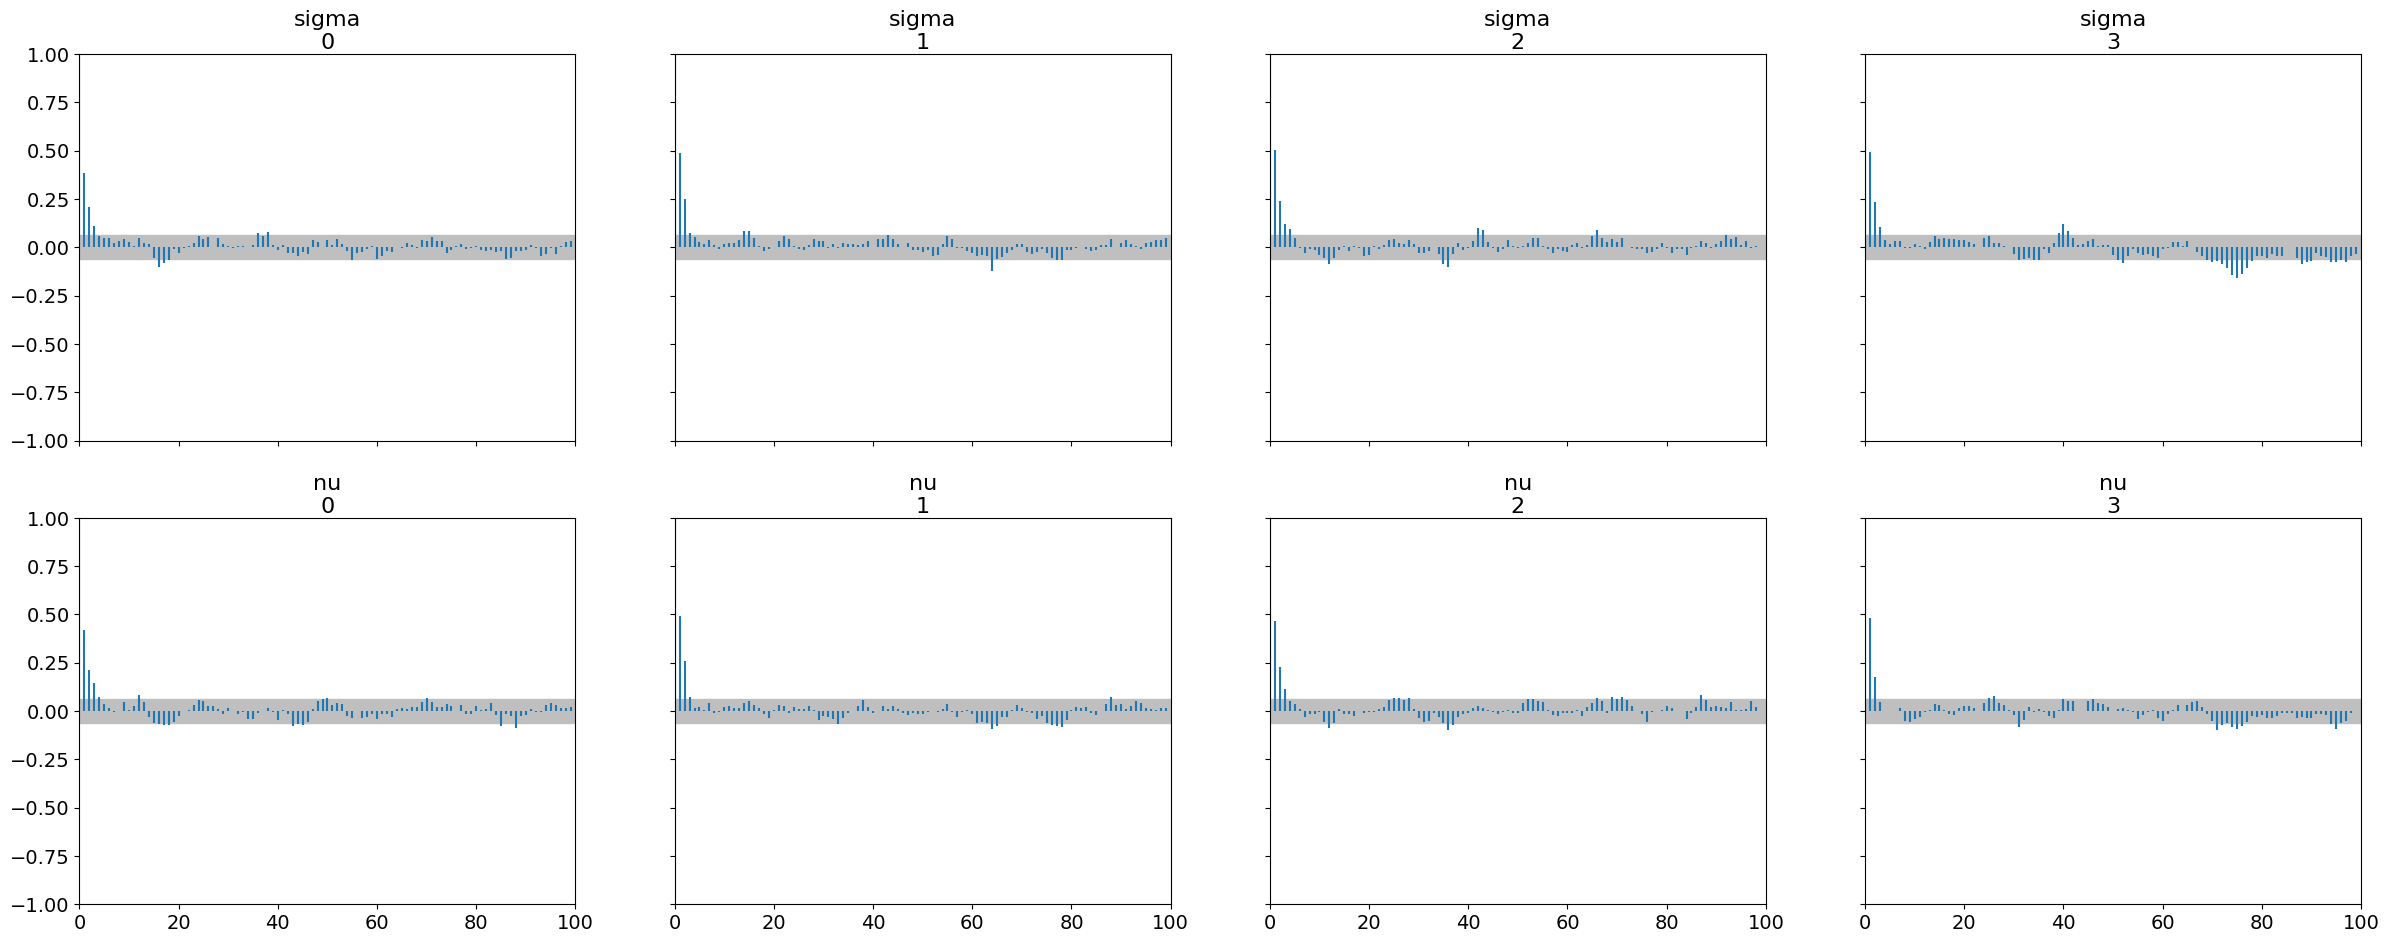

In [78]:
az.plot_autocorr(trace_h2, var_names=['sigma','nu'])

<img src="Plots/output13.png">

Here we can spot rapid decay of autocorrelation  
- In all chains for sigma, autocorrelation at lag 1 is approximately 0.3–0.5, but by lag ≈ 10 it falls almost to zero.  
- Similarly for nu: initial autocorrelation is slightly lower (around 0.2–0.4), and by lag > 20 it converges fully to zero.

Also, there is consistency between the chains:
- The shapes of the autocorrelation profiles are very similar across chains 0–3 for both sigma and mu.  
- There is no “long tail” or erratic oscillations; all curves demonstrate monotonic decay.

Since autocorrelation nearly disappears after a few dozen samples, draws separated by more than 20 iterations can be considered virtually independent.  

Combined with high ESS and $\hat{R} \approx 1.00$, this confirms that the chains are well-mixed and the posterior distributions for sigma and nu can be used without concern for strong sample dependence.

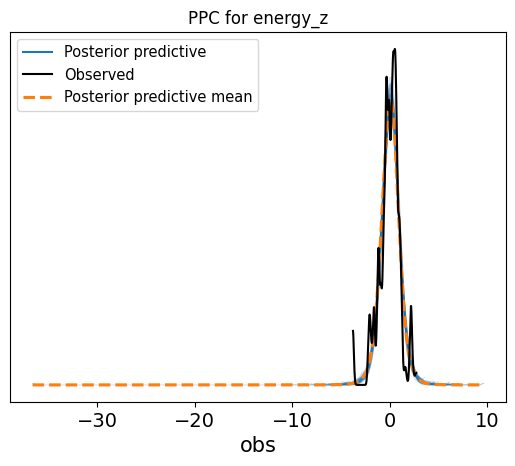

In [79]:
az.plot_ppc(
    idata_h2,
    var_names=["obs"],
    kind="kde",
    num_pp_samples=40
)
plt.title("PPC for energy_z")
plt.show()

<img src="Plots/output14.png">

The peaks of the blue cloud and the black line align almost exactly around zero, indicating that the model accurately reproduces the bulk of the observations.

The blue curves show a slight spread around the central peak, with their width and shape very close to the real data. This means that sigma and nu in the Student-t errors adequately capture the variability.

Also, it can be seen that some blue curves have slightly heavier tails than the observed curve, but the average orange curve practically coincides with the real one within +-3. Thus, the model is capable of generating outliers similar to those in the data without overestimating their frequency.

So, the fitted Student-t model with estimated nu ≈ 5 provides a good match between predictions and observations. The central part, tails, and outliers are all adequately reproduced, and the predictive uncertainty correctly reflects the spread of the real measurements.


In [80]:
beta_da = post["beta"]
beta_samples = beta_da.stack(samples=("chain","draw")).values

js_idx = int(language_map.query("Language=='javascript'")['language_idx'])

beta_js      = beta_samples[:, js_idx]                
beta_others  = np.delete(beta_samples, js_idx, axis=1)

deltas = beta_others - beta_js[:, None]

other_langs = language_map.query("Language!='javascript'")['Language'].tolist()
prob_js_lower_each = (deltas > 0).mean(axis=0)

print("P(β_js < β_f) for each language f:")
for lang, p in zip(other_langs, prob_js_lower_each):
    print(f"  javascript < {lang:10s}  →  {p:.3f}")

prob_js_lowest_all = np.mean(np.all(deltas > 0, axis=1))
print(f"\nP( javascript is the lowest β amongst all ) = {prob_js_lowest_all:.3f}")

P(β_js < β_f) for each language f:
  javascript < c-sharp     →  1.000
  javascript < go          →  1.000
  javascript < python      →  1.000
  javascript < ruby        →  1.000
  javascript < rust        →  1.000

P( javascript is the lowest β amongst all ) = 0.000


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_95804/1247397170.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  js_idx = int(language_map.query("Language=='javascript'")['language_idx'])


Here we compared the posterior effects for JavaScript beta_ with the effects for all other languages to answer the question: “How likely is it that JavaScript is less energy-efficient than each of them?”

**Preparation**  
- For each posterior draw we computed the difference  
  $$
    \delta = \beta_{\mathrm{js}} - \beta_{f},
  $$  
  where \(f\) is one of the other languages.  

Then, we calculated the fraction of draws in which delta > 0

**Pairwise comparison results**  
- The probability that the JavaScript effect is smaller than the C# effect: 1
- The probability that the JavaScript effect is smaller than the Go effect: 1
- The probability that the JavaScript effect is smaller than the Python effect: 1
- The probability that the JavaScript effect is smaller than the Ruby effect: 0.000
- The probability that the JavaScript effect is smaller than the Rust effect: 0.000

This means that JavaScript has almost 100% probability to be less energy-efficient than C#, Go and Python. However, in comparison with Ruby and Rust, JavScript has almost 0 pobability to consume less energy than the languages.

**Probability of the lowest effect overall**  
- We also computed the fraction of samples in which beta_js is the minimum among all languages.  
- That probability is 0.000. Virtually zero chance that JavaScript is the least energy-efficient language in our set.

These results show that JavaScript would prove to be the most energy-efficient language of our six in no MCMC sample.

Knowing these pairwise probabilities allows us to rank languages by efficiency. Languages that JavaScript almost never loses to can be deprioritized for optimization.
